# COURSE: PCA and multivariate neural signal processing
## SECTION: Dimension reduction with PCA
### VIDEO: Python: PCA on multi-trial data
#### Instructor: sincxpress.com

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import copy
import scipy.io as sio
# from mpl_toolkits.mplot3d import Axes3D
from pytopo import topoplotIndie

In [4]:
# mat file containing EEG, leadfield and channel locations
matfile = sio.loadmat('MATLAB_data_files/sampleEEGdata')
EEG = matfile['EEG'][0,0]
EEG['times'] = EEG['times'][0]

In [5]:
## erp ("phase-locked") covariance matrix

# time window to use
tidx1 = np.argmin(EEG['times'])
tidx2 = np.argmin(np.abs(EEG['times']-800))

# phase-locked covariance
erp  = np.mean(EEG['data'][:,tidx1:tidx2,:],axis=2)
data = copy.deepcopy(erp)

# mean-center and covariance matrix
for ci in range(int(EEG['nbchan'])):
    data[ci,:] -= np.mean(data[ci,:])

# and get the covariance matrix
cov_phaselocked = data@data.T / (int(EEG['pnts'])-1)

In [6]:
## single-trial ("total") covariance matrix

# initialize
cov_total = np.zeros((EEG['nbchan'][0][0],EEG['nbchan'][0][0]))

# loop over trials
for triali in range(EEG['trials'][0][0]):
    
    # data covariance from this trial
    minicov = np.cov( EEG['data'][:,tidx1:tidx2,triali] )
    
    # add to the mix
    cov_total += minicov


# scale by N
cov_total /= triali

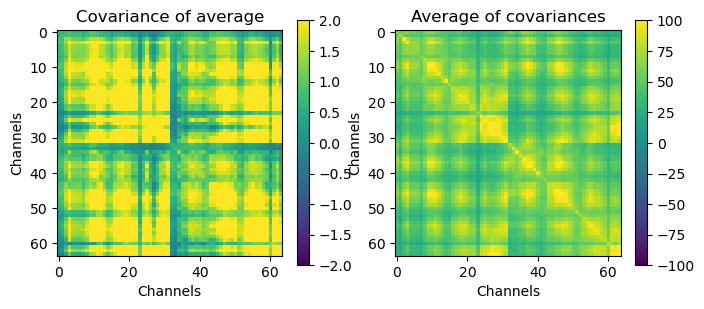

In [7]:
## visualize the two covariance matrices

fig,axs = plt.subplots(1,2,figsize=(8,5))
fig.subplots_adjust(top=0.6)

h = axs[0].imshow(cov_phaselocked,vmin=-2,vmax=2)
axs[0].set_xlabel('Channels')
axs[0].set_ylabel('Channels')
axs[0].set_title('Covariance of average')
plt.colorbar(h,ax=axs[0])

h = axs[1].imshow(cov_total,vmin=-100,vmax=100)
axs[1].set_xlabel('Channels')
axs[1].set_ylabel('Channels')
axs[1].set_title('Average of covariances')
plt.colorbar(h,ax=axs[1])

# plt.tight_layout()
plt.show()

In [8]:
## compute PCA on ERP

# eigendecomposition
L_PL,V_PL = np.linalg.eig( cov_phaselocked )

# sort according to eigenvalues
soidx = np.argsort(L_PL)[::-1]
L_PL  = L_PL[soidx]
V_PL  = V_PL[:,soidx]

# convert eigenvalues to %change
L_PL = 100*L_PL / np.sum(L_PL)

# principal component time series
# NOTE: applying filter to the entire time series!
compts_PL = V_PL[:,0].T @ np.mean(EEG['data'],axis=2)

In [9]:
## repeat for total covariance

# eigendecomposition
L_TT,V_TT = np.linalg.eig( cov_total )

# sort according to eigenvalues
soidx = np.argsort(L_TT)[::-1]
L_TT  = L_TT[soidx]
V_TT  = V_TT[:,soidx]

# convert eigenvalues to %change
L_TT = 100*L_TT / np.sum(L_TT)

# principal components time series
# data are 3D, so we reshape to 2D, project, then reshape back
data2d    = np.reshape(EEG['data'],[EEG['nbchan'][0][0],-1],order='F')
comptmp   = V_TT[:,0].T @ data2d
compts_TT = np.reshape(comptmp,[EEG['pnts'][0][0],EEG['trials'][0][0]],order='F')

# then compute the trial average
compTT_erp = np.mean(compts_TT,axis=1)

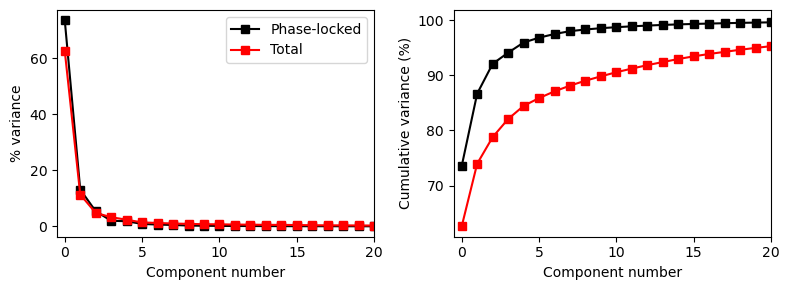

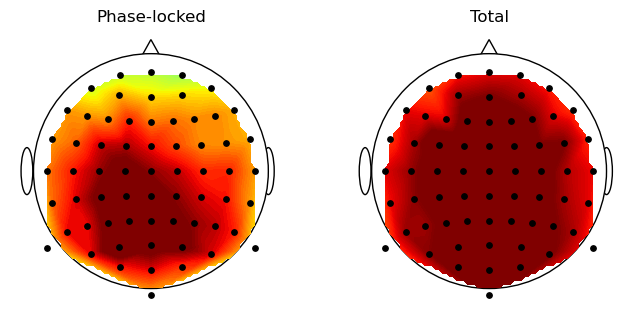

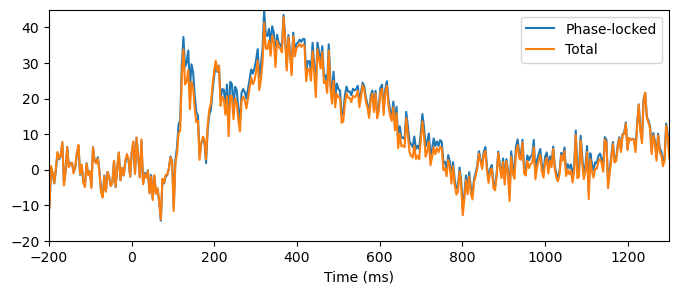

In [10]:
## visualize the results
_,axs = plt.subplots(1,2,figsize=(8,3))

# scree plots
axs[0].plot(L_PL,'ks-',label='Phase-locked')
axs[0].plot(L_TT,'rs-',label='Total')
axs[0].set_xlim([-.5,20])
axs[0].set_xlabel('Component number')
axs[0].set_ylabel('% variance')
axs[0].legend()

# cumulative scree plots
axs[1].plot(np.cumsum(L_PL),'ks-',label='Phase-locked')
axs[1].plot(np.cumsum(L_TT),'rs-',label='Total')
axs[1].set_xlim([-.5,20])
axs[1].set_xlabel('Component number')
axs[1].set_ylabel('Cumulative variance (%)')

plt.tight_layout()
plt.show()


# show topomaps
_,axs = plt.subplots(1,2,figsize=(8,4))
topoplotIndie(-V_PL[:,0],EEG['chanlocs'],'Phase-locked',axs[0])
topoplotIndie(V_TT[:,0],EEG['chanlocs'],'Total',axs[1])
plt.show()


# show ERPs
plt.figure(figsize=(8,3))
plt.plot(EEG['times'],-compts_PL,label='Phase-locked')
plt.plot(EEG['times'],compTT_erp,label='Total')
plt.xlim([-200,1300])
plt.ylim([-20,45])
plt.xlabel('Time (ms)')
plt.legend()

plt.show()